## conservation of mutations linked to drug resistance

Use the "Run" button to execute the code.

In [1]:
!pip install jovian --upgrade --quiet

In [2]:
import jovian

In [3]:
# Execute this to save new versions of the notebook
jovian.commit(project="mutation_drug_resistance_genes", filename="mutation_drug_resistance_genes")

<IPython.core.display.Javascript object>

[jovian] Updating notebook "anubratadas/mutation-drug-resistance-genes" on https://jovian.ai
[jovian] Committed successfully! https://jovian.ai/anubratadas/mutation-drug-resistance-genes


'https://jovian.ai/anubratadas/mutation-drug-resistance-genes'

In [4]:
import requests
import time
import xml.etree.ElementTree as ET
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [45]:
# from PMC Database
url="https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi" # base url
def get_values(): 
    db_list=["pmc"]
    term=["TLS polymerase AND 'nuclear localization'"]  
    count_dict={}
    count_dict['term']=term # populate the terms in the dictionary      
    response_lst=[]
    for item in term:
        time.sleep(1)
        try:
            payload={"db":"pmc","term":item,"retype":"count","retmax":10000,"email":"anubratadas@gmail.com","api_key":"9577c7078191e23dfdd5015746af31abf708" } # parameters
            response=requests.get(url,params=payload) # response object
            tree=ET.fromstring(response.content) # tree obtained directly from response.content using fromstring
            count=tree.find('Count').text
            #print(count)
            response_lst.append(count)                
        except error:
            print(error)  
    count_dict['reports']=response_lst   
    #mutation_dict= {"term":term,str(db):response_lst}    
    return  count_dict # return count of listings
                   
count_dict=get_values()

In [46]:
df_mutation=pd.DataFrame(count_dict)
df_mutation['reports']=pd.to_numeric(df_mutation['reports'])
#df_mutation['reports']=df_mutation['reports'].map(lambda x:np.log(x))
df_mutation.dtypes

term       object
reports     int64
dtype: object

In [47]:
df_mutation

,term,reports
0,TLS polymerase AND 'nuclear localization',1


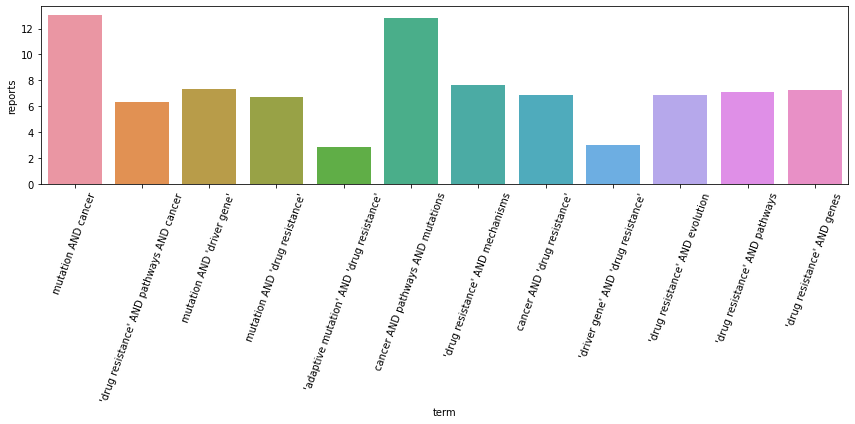

In [61]:
plt.figure(figsize=(12, 6))
plt.title('')
sns.barplot(data=df_mutation,x='term',y='reports');
plt.xticks(rotation=70)
plt.tight_layout()

In [57]:
# from PMC Database
url="https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi" # base url
def get_efetch_uids(item): 
    uid_lst=[] # list object to collect the uids generated by Esearch    
    try:
        payload={"db":"pmc","term":item,"retype":"count","retmax":100000,"email":"anubratadas@gmail.com","api_key":"9577c7078191e23dfdd5015746af31abf708" } # parameters
        response=requests.get(url,params=payload) # response object
        response.raise_for_status()
        root=ET.fromstring(response.content) # tree obtained directly from response.content using fromstring
        id_list=root.find('IdList')   
        return id_list
    except requests.exceptions.HTTPError as err:
        raise SystemExit(err)
    except requests.exceptions.TooManyRedirects:
        print("please try a different URL")
            
def call_efetch(): # removed "cancer AND mutations" and "cancer AND pathways AND mutations"
    term=["DNA polymerase AND 'nuclear localization'"]  
    uid_list=[]
    for item in term:
        time.sleep(1)
        id_list=get_efetch_uids(item)        
        for id_num in id_list:
            uid_list.append(id_num.text)
    uid=",".join(uid_list) 
    print(f' {len(uid_list)} records retrieved')
    return uid
uid=call_efetch()

 95 records retrieved


In [43]:
# Esummary with the string variable from Esearch passed to id parameter of Esummary
# since we have more than 200 records we have to use post
url_summ="https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?"
payload={"db":"pmc","id":uid,"email":"anubratadas@gmail.com","api_key":"9577c7078191e23dfdd5015746af31abf708" } 
response_esumm_uid=requests.get(url_summ,params=payload) # response object
esummary_root_et=ET.fromstring(response_esumm_uid.content)

In [44]:
with open("ploymerase_refs.txt","w") as fh:
    for child in ET.fromstring(response_esumm_uid.content):
        for subchild in child:
            try:
                fh.write(subchild.text)   
            except:
                continue                

as the list of files were large in number, the server refused connection

now we will chunk up the list of files into units of 1000

In [15]:
# this function creates sublists of 200 entries each for getting esummary records

def chunk_list():
    master_list_=[]
    add_list=[]  # create a temporary list variable
    new_uid_list=uid.split(",") # create a list of UIDs back from the string generated earlier by merging the UIDs
    print(len(new_uid_list))
    a=200 # select the chunk size
    while len(new_uid_list)>=0:  # check that input list is nonzero
        add_list=new_uid_list[:a]   # append the first 200 entries from input to the temporary list variable
        del new_uid_list[:a]        # delete the entries transferred to the temporary list from the input list   
        master_list_.append(add_list)    
        if len(new_uid_list)<=0:
            break   
    return master_list_         
master_list=chunk_list()

5868


In [16]:
master_list[0][1:10]

['8257504',
 '8287939',
 '8275338',
 '8243336',
 '8265155',
 '8262728',
 '8256890',
 '8248980',
 '8225391']

In [17]:
# this code snippet will change the UIDs in the sublist back into strings for searching with esummary as a parameter
def uid_string_convert(master_list):
    uid_string_list=[]
    for sublist in master_list:
        str_uid=",".join(sublist)
        uid_string_list.append(str_uid)
    print(len(uid_string_list))
    return uid_string_list


def get_summary():
    uid_string_list=uid_string_convert(master_list)
    for uid_string in uid_string_list:    
        url_summ="https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?"
        payload={"db":"pmc","id":uid_string,"email":"anubratadas@gmail.com","api_key":"9577c7078191e23dfdd5015746af31abf708" } 
        time.sleep(1)                                              # server throttle
        response_esumm_uid=requests.get(url_summ,params=payload)   # response object
        esummary_root_et=ET.fromstring(response_esumm_uid.content) # get content
        docsum=esummary_root_et.findall('DocSum')                  # find document
        return docsum

def parse_docsum():
    title_dict={"uid":[],"title":[]}
    title_list=[]
    uid_list=[]
    docsum_list=get_summary()
    for entry in docsum_list:
        id_=entry.find('Id')
        #print(id.text)
        uid_list.append(id_.text)
        title=entry.find('Item[@Name="Title"]')
        #print(title.text)
        title_list.append(title.text)
    title_dict["title"]=title_list
    title_dict["uid"]=uid_list
    return title_dict

title_dict=parse_docsum()
search_title=pd.DataFrame(title_dict)
search_title_csv=search_title.to_csv("ncbi_search_titles_pmc.csv")

30


In [18]:
search_title

,uid,title
0,8303718,Functional Roles of Bromodomain Proteins in Ca...
1,8257504,The genome of Nautilus pompilius illuminates e...
2,8287939,The phase separation-dependent FUS interactome...
3,8275338,A novel constrained genetic algorithm-based Bo...
4,8243336,"At elevated temperatures, heat shock protein g..."
...,...,...
195,6916592,Genotype‐guided diagnostic reassessment after ...
196,6813942,CRISPR’d babies: human germline genome editing...
197,6785828,Modeling monogenic diabetes using human ES cel...
198,6715855,The roles of the human SETMAR (Metnase) protei...


In [19]:
# Esummary with the string variable from Esearch passed to id parameter of Esummary
# since we have more than 200 records we have to use post
url_summ="https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?"
payload={"db":"pubmed","id":"8021012","email":"anubratadas@gmail.com","api_key":"9577c7078191e23dfdd5015746af31abf708" } 
response_esumm_uid=requests.post(url_summ,params=payload) # response object
esummary_root_et=ET.fromstring(response_esumm_uid.content)

In [20]:
esummary_root_et.find('DocSum/Item[@Name="Title"]').text

'Vascular hypertrophy in renal hypertensive spontaneously hypertensive rats.'

In [21]:
esummary_root_et.find('DocSum/Id').text

'8021012'

In [98]:
jovian.commit(project="mutation_drug_resistance_genes", filename="mutation_drug_resistance_genes")

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/anubratadas/mutation-drug-resistance-genes


'https://jovian.ai/anubratadas/mutation-drug-resistance-genes'

#### now we shall try to get the records

In [23]:
fetch_url=",".join(master_list[0])

In [24]:
fetch_url

'8303718,8257504,8287939,8275338,8243336,8265155,8262728,8256890,8248980,8225391,8235170,8232626,8221386,8187381,8077053,8192126,8118313,8151074,8130048,8125410,8082263,8073968,8043407,8066772,7990087,8093989,8021012,7979703,7945669,8088342,7970106,7926393,7898014,7922087,8008486,7925619,7937031,7914857,7913311,7851172,8075535,7865432,7986148,7838904,8131040,8034535,7837469,7877913,7861014,7802155,7794078,7786334,7782688,7943042,7738981,7823342,7785249,7747571,7738555,7744054,7596405,7684970,7904073,7725327,7724325,7966638,7709044,7778899,7689034,7656703,7752041,7651821,7710505,7648144,7604749,7779059,7661550,7591249,7779011,7861016,7576724,7900948,7779053,7557149,8208305,7549480,7509766,7660261,7569937,7790753,7674757,7575970,7555362,7444254,7471748,7464555,7452722,7463534,7710562,7423336,7398276,7116779,7387688,7386301,7397227,7520283,7390454,7404684,7355253,7401007,7335045,7333331,7430637,7680530,7339035,7501820,7293170,7287090,7388439,7252619,7251935,7666068,7216732,7226225,7211031

In [25]:
response_efetch=requests.get("https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi",params={"db":"pmc","id":'6650054',"format":"xml"})

In [26]:
print(response_efetch.raise_for_status())

None


In [27]:
!conda install lxml --yes --quiet

/bin/bash: conda: command not found


In [28]:
from lxml import etree
from io import StringIO, BytesIO

In [29]:
root=etree.parse(StringIO(response_efetch.text))

In [30]:
# view the layout of the tree objectobject
print(etree.tostring(root))

b'<!DOCTYPE pmc-articleset PUBLIC "-//NLM//DTD ARTICLE SET 2.0//EN" "https://dtd.nlm.nih.gov/ncbi/pmc/articleset/nlm-articleset-2.0.dtd">\n<pmc-articleset><article xmlns:xlink="http://www.w3.org/1999/xlink" xmlns:mml="http://www.w3.org/1998/Math/MathML" article-type="research-article">\n  <?properties open_access?>\n  <front>\n    <journal-meta>\n      <journal-id journal-id-type="nlm-ta">PLoS One</journal-id>\n      <journal-id journal-id-type="iso-abbrev">PLoS ONE</journal-id>\n      <journal-id journal-id-type="publisher-id">plos</journal-id>\n      <journal-id journal-id-type="pmc">plosone</journal-id>\n      <journal-title-group>\n        <journal-title>PLoS ONE</journal-title>\n      </journal-title-group>\n      <issn pub-type="epub">1932-6203</issn>\n      <publisher>\n        <publisher-name>Public Library of Science</publisher-name>\n        <publisher-loc>San Francisco, CA USA</publisher-loc>\n      </publisher>\n    </journal-meta>\n    <article-meta>\n      <article-id pub

In [31]:
# using element tree
title_from_element_tree=[element for element in root.iter() if element.tag=='article-title'][0].text

In [32]:
title=root.xpath('//article-title/text()')[0]
title

'A meta-analysis of multiple matched aCGH/expression cancer datasets reveals regulatory relationships and pathway enrichment of potential oncogenes'

In [33]:
# using element tree
for element in root.iter():
    if element.tag=='abstract':
        abstract_tag=element       

In [34]:
for sub_element in abstract_tag:
    if sub_element.tag=='p':
        print(sub_element.text) # the formatting for POGZ disrupts the text formatting

The copy numbers of genes in cancer samples are often highly disrupted and form a natural amplification/deletion experiment encompassing multiple genes. Matched array comparative genomics and transcriptomics datasets from such samples can be used to predict inter-chromosomal gene regulatory relationships. Previously we published the database METAMATCHED, comprising the results from such an analysis of a large number of publically available cancer datasets. Here we investigate genes in the database which are unusual in that their copy number exhibits consistent heterogeneous disruption in a high proportion of the cancer datasets. We assess the potential relevance of these genes to the pathology of the cancer samples, in light of their predicted regulatory relationships and enriched biological pathways. A network-based method was used to identify enriched pathways from the genes’ inferred targets. The analysis predicts both known and new regulator-target interactions and pathway membersh

In [35]:
# using xpath
abstract_list=root.xpath('//abstract//p//text()') # the formatting for POGZ disrupts the text formatting
abstract="".join(abstract_list)                   # the list obtained is combined as text  
abstract

'The copy numbers of genes in cancer samples are often highly disrupted and form a natural amplification/deletion experiment encompassing multiple genes. Matched array comparative genomics and transcriptomics datasets from such samples can be used to predict inter-chromosomal gene regulatory relationships. Previously we published the database METAMATCHED, comprising the results from such an analysis of a large number of publically available cancer datasets. Here we investigate genes in the database which are unusual in that their copy number exhibits consistent heterogeneous disruption in a high proportion of the cancer datasets. We assess the potential relevance of these genes to the pathology of the cancer samples, in light of their predicted regulatory relationships and enriched biological pathways. A network-based method was used to identify enriched pathways from the genes’ inferred targets. The analysis predicts both known and new regulator-target interactions and pathway members

In [36]:
conclusions

NameError: ignored

In [ ]:
for section in conclusions:
    for element in section.iter():
        if element.tag=="Discussion":
            print(element.text)
       

In [ ]:
for section in conclusions:
    for element in section.iter("title"):       
            print(element.text)       

In [ ]:
discussion=""
for section in conclusions:
    if section.findtext('title')=="Discussion":
        for element in section.getchildren():
            if element.tag=='p':
                discussion=discussion+element.text

In [ ]:
discussion

In [67]:
with open('resMut.tsv','r') as fh:
  data=fh.readlines()

In [69]:
data[:5]

['Sample Name\tSample ID\tGene Name\tTranscript\tCensus Gene\tDrug Name\tMUTATION_ID\tGENOMIC_MUTATION_ID\tLEGACY_MUTATION_ID\tAA Mutation\tCDS Mutation\tPrimary Tissue\tTissue Subtype 1\tTissue Subtype 2\tHistology\tHistology Subtype 1\tHistology Subtype 2\tPubmed Id\tCGP Study\tSomatic Status\tSample Type\tZygosity\tGenome Coordinates (GRCh38)\tTier\tHGVSP\tHGVSC\tHGVSG\n',
 '3\t1330179\tKRAS_ENST00000556131\tENST00000556131.1\tNo\tCetuximab\t153544881\tCOSV55497388\tCOSM532\tp.G13D\tc.38G>A\tlarge_intestine\tcolon\ttransverse\tcarcinoma\tadenocarcinoma\tNS\t20361188\t\tPreviously Reported\tTumour Sample\tUnknown\t12:25245347..25245347\t\tENSP00000451856.1:p.Gly13Asp\tENST00000556131.1:c.38G>A\t12:g.25245347C>T\n',
 'RPC-9\t1083085\tEGFR_ENST00000455089\tENST00000455089.5\tNo\tGefitinib\t127653906\tCOSV51765492\tCOSM6240\tp.T745M\tc.2234C>T\tlung\tNS\tNS\tcarcinoma\tadenocarcinoma\tNS\t17699786\t\tPreviously Reported\tCultured\tHeterozygous\t7:55181378..55181378\t\tENSP00000415559.1:

In [72]:
resistance_genes=pd.read_csv('resMut.tsv',sep='\t')

In [87]:
resistance_genes.head(n=3)

,Sample Name,Sample ID,Gene Name,Transcript,Census Gene,Drug Name,MUTATION_ID,GENOMIC_MUTATION_ID,LEGACY_MUTATION_ID,AA Mutation,CDS Mutation,Primary Tissue,Tissue Subtype 1,Tissue Subtype 2,Histology,Histology Subtype 1,Histology Subtype 2,Pubmed Id,CGP Study,Somatic Status,Sample Type,Zygosity,Genome Coordinates (GRCh38),Tier,HGVSP,HGVSC,HGVSG
0,3,1330179,KRAS,ENST00000556131.1,No,Cetuximab,153544881,COSV55497388,COSM532,p.G13D,c.38G>A,large_intestine,colon,transverse,carcinoma,adenocarcinoma,NS,20361188,NaN,Previously Reported,Tumour Sample,Unknown,12:25245347..25245347,NaN,ENSP00000451856.1:p.Gly13Asp,ENST00000556131.1:c.38G>A,12:g.25245347C>T
1,RPC-9,1083085,EGFR,ENST00000455089.5,No,Gefitinib,127653906,COSV51765492,COSM6240,p.T745M,c.2234C>T,lung,NS,NS,carcinoma,adenocarcinoma,NS,17699786,NaN,Previously Reported,Cultured,Heterozygous,7:55181378..55181378,NaN,ENSP00000415559.1:p.Thr745Met,ENST00000455089.5:c.2234C>T,7:g.55181378C>T
2,903861,903861,ABL1,ENST00000318560.5,No,Imatinib,101978508,COSV59325175,COSM12576,p.Y253H,c.757T>C,haematopoietic_and_lymphoid_tissue,NS,NS,haematopoietic_neoplasm,acute_leukaemia_of_ambiguous_lineage,NS,11853795,NaN,Variant of unknown origin,Tumour Sample,Homozygous,9:130862970..130862970,NaN,ENSP00000323315.5:p.Tyr253His,ENST00000318560.5:c.757T>C,9:g.130862970T>C


In [81]:
def trim_name(gene):
  if '_' in gene:
    gene=gene.split('_')[0]
  else:
    gene=gene  
  return gene  

In [83]:
resistance_genes['Gene Name']=resistance_genes['Gene Name'].map(trim_name)

In [97]:
resistance_genes.groupby(['Gene Name']).count().sort_values(by=['AA Mutation'],ascending=False).head(n=5)

,Sample Name,Sample ID,Transcript,Census Gene,Drug Name,MUTATION_ID,GENOMIC_MUTATION_ID,LEGACY_MUTATION_ID,AA Mutation,CDS Mutation,Primary Tissue,Tissue Subtype 1,Tissue Subtype 2,Histology,Histology Subtype 1,Histology Subtype 2,Pubmed Id,CGP Study,Somatic Status,Sample Type,Zygosity,Genome Coordinates (GRCh38),Tier,HGVSP,HGVSC,HGVSG
Gene Name,,,,,,,,,,,,,,,,,,,,,,,,,,
ABL1,1468,1468,1468,1468,1468,1468,382,1468,1468,1468,1468,1468,1468,1468,1468,1468,1468,0,1468,1468,1468,382,191,1323,382,382
EGFR,1069,1069,1069,1069,1069,1069,632,1069,1069,1069,1069,1069,1069,1069,1069,1069,1069,0,1069,1069,1069,632,595,910,632,632
ESR1,299,299,299,299,299,299,259,299,299,299,299,299,299,299,299,299,299,0,299,299,299,259,77,224,259,259
KIT,290,290,290,290,290,290,54,290,290,290,290,290,290,290,290,290,290,0,290,290,290,54,290,274,54,54
BTK,276,276,276,276,276,276,264,276,276,276,276,276,276,276,276,276,276,0,276,276,276,264,66,212,264,264


In [107]:
curated_genes=resistance_genes[resistance_genes['Gene Name'].isin(['ABL1','EGFR'])]

In [117]:
curated_genes=curated_genes.loc[:,['Gene Name','AA Mutation']].sort_values(by='Gene Name')

In [118]:
curated_genes

,Gene Name,AA Mutation
2187,ABL1,p.M244V
3640,ABL1,p.M351T
1933,ABL1,p.E478G
3646,ABL1,p.M388L
3647,ABL1,p.G250E
...,...,...
2088,EGFR,p.T790M
2079,EGFR,p.T790M
2071,EGFR,p.T745M
2108,EGFR,p.C752S
